# Simulations with flattened with odeint

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

# Old simulator without loops...
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = [246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(params):
    y = odeint(model, y0, t, args=(params,))
    return torch.tensor(y, dtype=torch.float32).flatten()
    
def unflatten(solution):
    variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
    solution_unflattened = torch.zeros((num_timesteps, len(variables)))
    for timestep in range(num_timesteps):
        for variable_idx, _ in enumerate(variables):
            solution_unflattened[timestep, variable_idx]=solution[timestep+variable_idx]
    return solution_unflattened

num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

true_data = simulator(true_params)

In [18]:
prior.sample((1,))

tensor([[248.0601, 209.2938,   5.4542]])

In [21]:
test = simulator_wrapper(prior.sample((3,)))
test.shape

torch.Size([3, 600])

In [2]:
##### paralellise #####

#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")


In [3]:
# Actual SNPE
num_rounds = 2
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 100
simulation_batch_size = 15

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

Running 100 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
posterior_samples

tensor([[186.0981, 189.4250, 196.9437],
        [210.2861,  23.6969, 216.1381],
        [188.4234, 206.1812, 196.1114],
        ...,
        [164.8596,  74.0631, 223.8351],
        [220.4902, 106.8476, 218.0477],
        [211.9913, 197.1505, 186.2437]])

In [13]:
import csv
num_param = 3
with open('flat_3k2r.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for p in range(num_param):
        writer.writerow([f"Param {p}"])
        for sample in posterior_samples:
            writer.writerow([sample[p].item()])
        writer.writerow([f" "])


In [22]:
column_name = ['k1','k2','k3']
snre_ss_pos = pd.DataFrame(data=posterior_samples, columns=column_name)
snre_ss_pos.to_csv('snpeflat3p.csv')

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
datatest = pd.read_csv('snpeflat3p.csv')

datatest

,Unnamed: 0,k1,k2,k3
0,0,186.09805,189.425020,196.94370
1,1,210.28615,23.696909,216.13810
2,2,188.42345,206.181230,196.11139
3,3,195.78186,96.604294,185.67316
4,4,224.05602,191.041410,179.70428
...,...,...,...,...
49995,49995,225.98929,199.103160,186.72462
49996,49996,195.51825,145.489730,203.54594
49997,49997,164.85959,74.063150,223.83510
49998,49998,220.49017,106.847610,218.04768


In [2]:
plot_k = pd.DataFrame(data=np.array([datatest["k1"], datatest["k2"], datatest["k3"]]), index=(r"$k_{1}$", r"$k_{2}$", r"$k_{3}$"))
plot_k

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
$k_{1}$,186.09805,210.286150,188.42345,195.781860,224.05602,188.70491,183.36725,225.87290,192.74896,200.89923,...,175.86896,232.05591,211.94414,197.76543,230.65782,225.98929,195.51825,164.85959,220.49017,211.99129
$k_{2}$,189.42502,23.696909,206.18123,96.604294,191.04141,151.89629,158.05855,145.77350,194.20592,130.96722,...,95.05354,212.52368,239.87483,139.76982,214.15874,199.10316,145.48973,74.06315,106.84761,197.15045
$k_{3}$,196.94370,216.138100,196.11139,185.673160,179.70428,165.41507,190.03287,237.32799,170.78441,198.90930,...,188.01587,221.26628,196.99402,182.15085,178.59322,186.72462,203.54594,223.83510,218.04768,186.24371


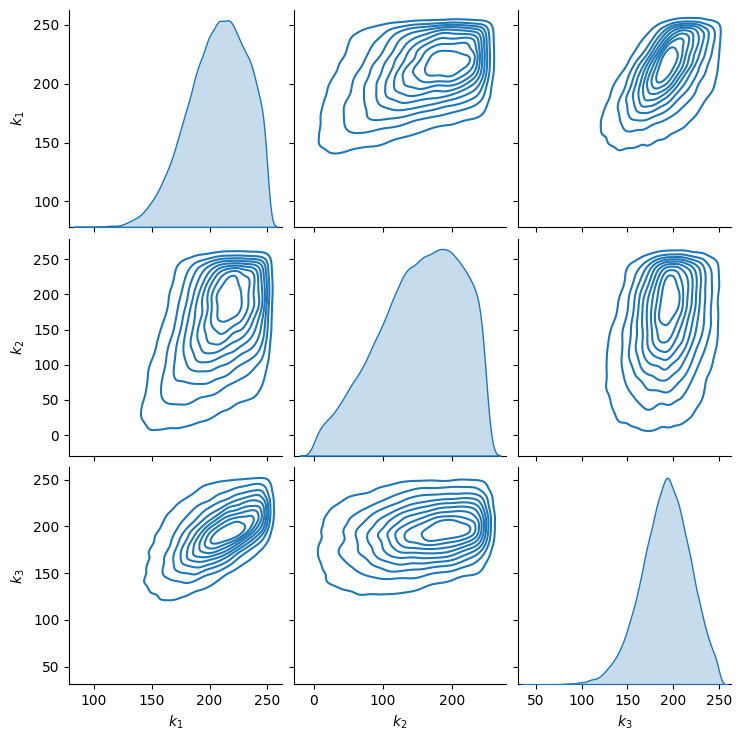

In [4]:
plot_k_t = pd.DataFrame.transpose(plot_k)
g = sns.pairplot(plot_k_t, kind="kde")
g

In [8]:
plot_k_t

,$k_{1}$,$k_{2}$,$k_{3}$
0,186.09805,189.425020,196.94370
1,210.28615,23.696909,216.13810
2,188.42345,206.181230,196.11139
3,195.78186,96.604294,185.67316
4,224.05602,191.041410,179.70428
...,...,...,...
49995,225.98929,199.103160,186.72462
49996,195.51825,145.489730,203.54594
49997,164.85959,74.063150,223.83510
49998,220.49017,106.847610,218.04768


In [12]:
plot_k_t.iloc[0,0:3].values

array([186.09805, 189.42502, 196.9437 ])

In [15]:
#trajectories quantile
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]
t = np.linspace(0, 100, 100)
def solve_ode(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    y = odeint(model, initial_conditions, t, args=(theta,))
    return y
from scipy.integrate import odeint
raw_trajectories=np.zeros([10000,100,6]) #first dim:no of samples, 100 time points, 6 trajec
for i in range(raw_trajectories.shape[0]):
    raw_trajectories[i]=solve_ode(plot_k_t.iloc[i,:].values, ).reshape(100,6)
tr=np.percentile(raw_trajectories, [2.5, 97.5], axis=0)      #import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
true_data = solve_ode(true_params)
fig, ax=plt.subplots(3,2,figsize=(15,9))
ax = ax.ravel()
col=["blue","blue"]
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    for j in range(2):
        ax[i].plot(tr[j,:,i],alpha=0.4,linestyle='dotted',linewidth=1,color='black')
    ax[i].plot(true_data.reshape(100,6)[:,i],linewidth=0.6,color='black')
    ax[i].fill_between(np.linspace(0,100,100),tr[0, :, i],tr[1, :, i],alpha=0.4,color='skyblue')

NameError: name 'plt' is not defined

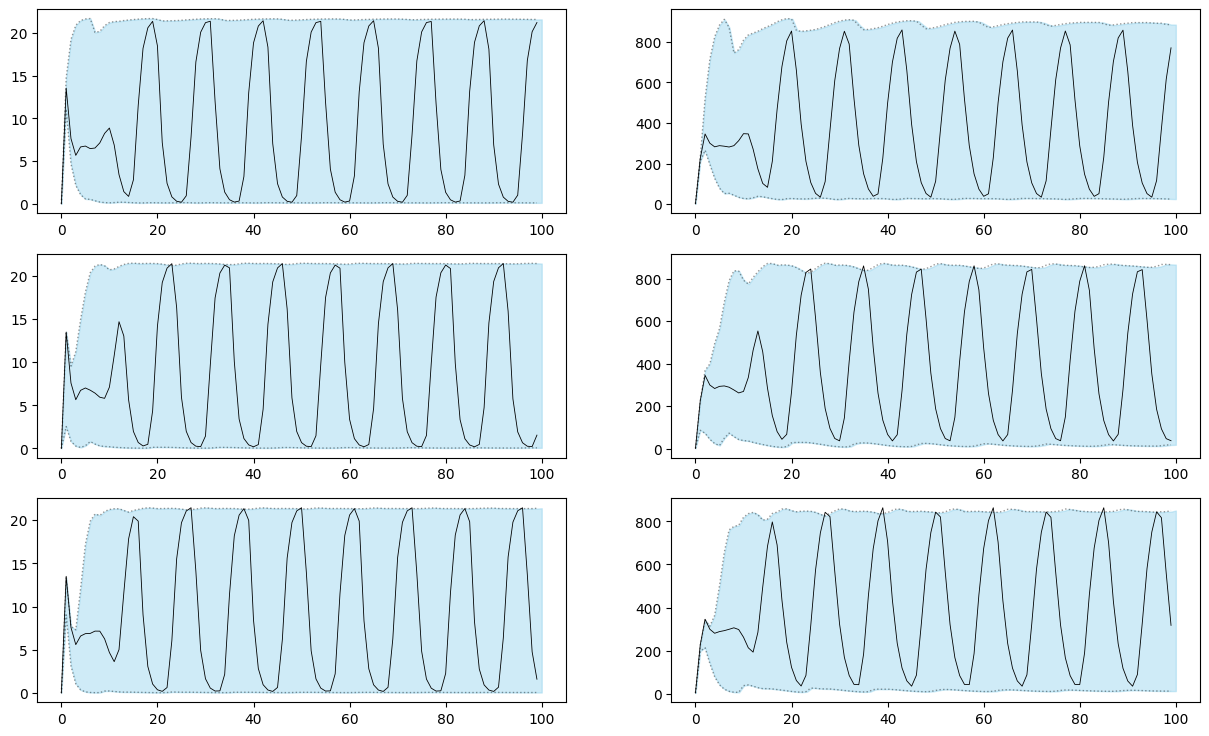

In [17]:
import matplotlib.pyplot as plt
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
true_data = solve_ode(true_params)
fig, ax=plt.subplots(3,2,figsize=(15,9))
ax = ax.ravel()
col=["blue","blue"]
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    for j in range(2):
        ax[i].plot(tr[j,:,i],alpha=0.4,linestyle='dotted',linewidth=1,color='black')
    ax[i].plot(true_data.reshape(100,6)[:,i],linewidth=0.6,color='black')
    ax[i].fill_between(np.linspace(0,100,100),tr[0, :, i],tr[1, :, i],alpha=0.4,color='skyblue')

# Now bigger simulation 5 rounds

In [ ]:
# Actual SNPE
num_rounds = 5
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 3000
simulation_batch_size = 40

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Same but with 6 params

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

# Old simulator without loops...
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3, a1, a2, a3 = params #only 3 ks are parameters to infer
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542,
    24.78485282457379, 24.78485282457379, 24.78485282457379]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)
    
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),
    high=torch.tensor([250.,250.,250.,40.,40.,40.])
)

true_data = simulator(true_params)

In [ ]:
##### paralellise #####

#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")


Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 153 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 70 epochs.

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

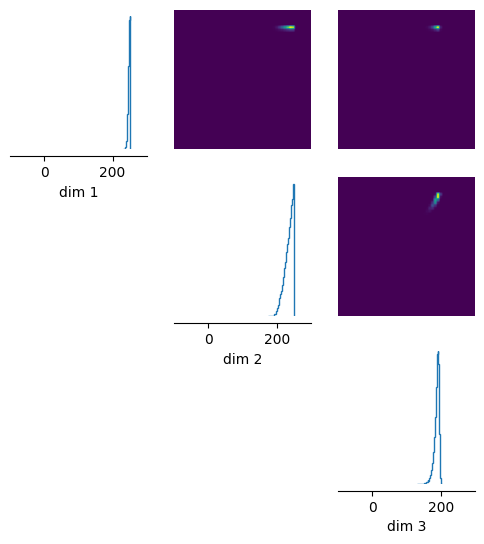

In [ ]:
# Actual SNPE
num_rounds = 2
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 3000
simulation_batch_size = 400

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Now bigger simulation 5 rounds

In [ ]:
# Actual SNPE
num_rounds = 5
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 3000
simulation_batch_size = 400

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)